# Simple Algorthmic Trading Programme

A basic algorithmic trading programme that uses technical indicators (i.e. Simple Moving Averages) to generate buy/sell signals.

## Install the packages and download the data

In [1]:
# Install if "ModuleNotFoundError: No module named 'yfinance'" occurs
# !pip install yfinance

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Download the data
df = yf.download("TSLA",
                 start="2020-01-01",
                 end="2024-11-08",
                 progress=False)

In [4]:
# Display the first 5 rows of the data
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-01-02 00:00:00+00:00,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03 00:00:00+00:00,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06 00:00:00+00:00,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07 00:00:00+00:00,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08 00:00:00+00:00,32.809334,32.809334,33.232666,31.215334,31.580000,467164500


## Data Cleaning
Checking for missing values, dropping missing values and isolating the column of data desired (i.e. closing prices)

In [5]:
# Check the data types of the columns
df.dtypes

Price      Ticker
Adj Close  TSLA      float64
Close      TSLA      float64
High       TSLA      float64
Low        TSLA      float64
Open       TSLA      float64
Volume     TSLA        int64
dtype: object

In [6]:
missing_values =  df.isna().sum().sort_values(ascending=False)
print(missing_values)

Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64


## Calculating the Simple Moving Averages

Code explanation:
- First we are defining the variable of days with 20 days being the short moving average and 50 days as the long moving average.
- On the price closing data, we perform the average on the timeframe of 20 and 50 days using the rolling method.
- In time-series data, the rolling function takes a window size of k at a time and perform some desired mathematical operation on it.

In [7]:
# Short Term MA (SMA) of 20 days and Long Term MA (LMA) of 50 days
short = 20
long = 50

# SMA Calculation
df['SMA'] = df['Close'].rolling(window=short, min_periods=1).mean()
df['LMA'] = df['Close'].rolling(window=long, min_periods=1).mean()

# Display first 10 rows of the new dataframe
df[['Close', 'SMA', 'LMA']].head(10)

Price,Close,SMA,LMA
Ticker,TSLA,,
Date,,,
2020-01-02 00:00:00+00:00,28.684000,28.684000,28.684000
2020-01-03 00:00:00+00:00,29.534000,29.109000,29.109000
2020-01-06 00:00:00+00:00,30.102667,29.440222,29.440222
2020-01-07 00:00:00+00:00,31.270666,29.897833,29.897833
2020-01-08 00:00:00+00:00,32.809334,30.480133,30.480133
2020-01-09 00:00:00+00:00,32.089333,30.748333,30.748333
2020-01-10 00:00:00+00:00,31.876667,30.909524,30.909524
2020-01-13 00:00:00+00:00,34.990665,31.419667,31.419667


### Plotting the Moving Averages

Using the matplotlib library to plot the data

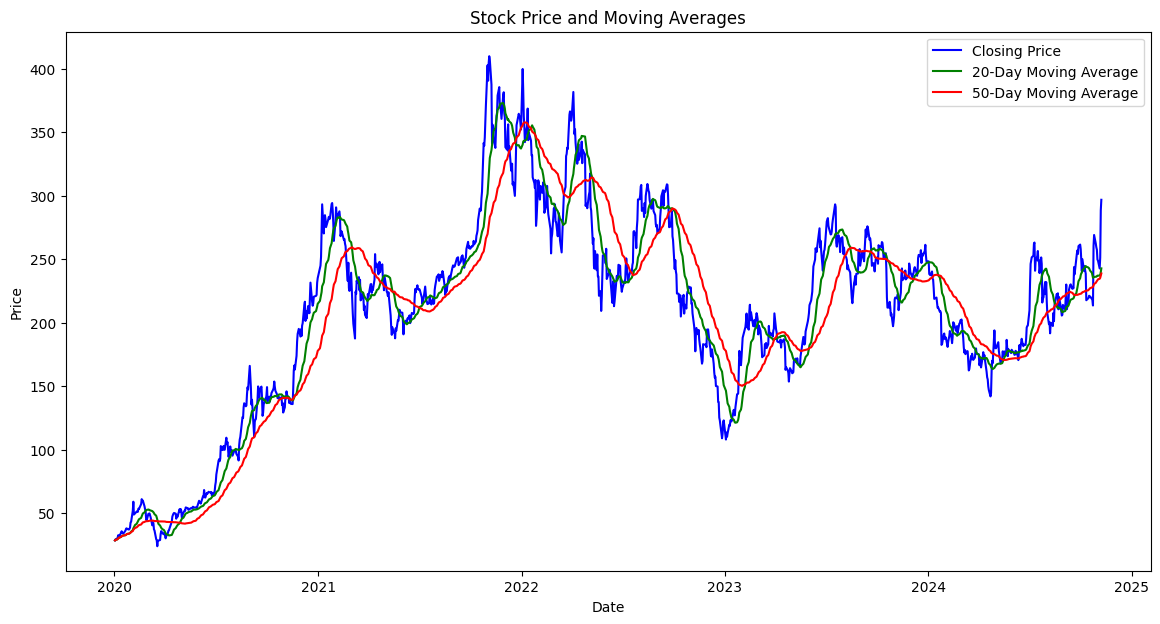

In [8]:
# Plot and display moving averages and prices
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['SMA'], label=f'{short}-Day Moving Average', color='green')
plt.plot(df['LMA'], label=f'{long}-Day Moving Average', color='red')

plt.title('Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

## Generating Trading Signals

The Buy and Sells signals:
Buy Signal: When the short-term moving average crosses above the long-term moving average
Sell Signal: When the short-term moving average crosses below the long-term moving average

Code logic:
1. Creating a new column in the dataframe called signal and setting every row to zero. This column will store 1 for buy signal and -1 for sell signals.
2. The signal will change from 0 to 1 or -1 only when there’s a crossover; otherwise, it remains 0

In [9]:
# Initialise the Signal Column
df['Signal'] = 0

# Create conditions for signalling
df['Signal'] = np.where(df['SMA'] > df['LMA'], 1, df['Signal'])
df['Signal'] = np.where(df['SMA'] < df['LMA'], -1, df['Signal'])

In [10]:
def calculate_position(df, signal_col='Signal'):
  """Calculates the trading position based on the signal.

  Args:
    df: The DataFrame containing the signal column.
    signal_col: The name of the column containing the signal.

  Returns:
    A Series indicating the trading position for each row.
  """

  current_signal = df[signal_col]
  previous_signal = df[signal_col].shift(1)

  # Buy conditions:
  buy_condition_1 = (current_signal == 1) & (previous_signal == 0)  # 0 to 1
  buy_condition_2 = (current_signal == 1) & (previous_signal == -1)  # -1 to 1

  # Sell conditions:
  sell_condition_1 = (current_signal == -1) & (previous_signal == 0)  # 0 to -1
  sell_condition_2 = (current_signal == -1) & (previous_signal == 1)  # 1 to -1

  return np.where(buy_condition_1 | buy_condition_2, 1, 
                   np.where(sell_condition_1 | sell_condition_2, -1, 0))

In [11]:
# Calculate the Position and add column to the dataframe
df['Position'] = calculate_position(df)

In [12]:
# Show DataFrame with Signals and Positions
df[['Close', 'SMA', 'LMA', 'Signal', 'Position']].tail(10)

Price,Close,SMA,LMA,Signal,Position
Ticker,TSLA,,,,
Date,,,,,
2024-10-25 00:00:00+00:00,269.190002,236.207502,230.569401,1,0
2024-10-28 00:00:00+00:00,262.510010,236.251502,231.497201,1,0
2024-10-29 00:00:00+00:00,259.519989,236.326502,232.233201,1,0
2024-10-30 00:00:00+00:00,257.549988,236.753001,232.962201,1,0
2024-10-31 00:00:00+00:00,249.850006,237.212502,233.493801,1,0
2024-11-01 00:00:00+00:00,248.979996,237.157501,234.260201,1,0
2024-11-04 00:00:00+00:00,242.839996,237.258001,234.710600,1,0
2024-11-05 00:00:00+00:00,251.440002,237.605001,235.475200,1,0


In [13]:
# Checking if function generates buy and sell signals
df['Signal'].value_counts()

Signal
 1    694
-1    508
 0     20
Name: count, dtype: int64

In [14]:
# Checking if function captures buy and sell signals correctly
df['Position'].value_counts()

Position
 0    1195
 1      14
-1      13
Name: count, dtype: int64

### Plotting Buy and Sell Signals

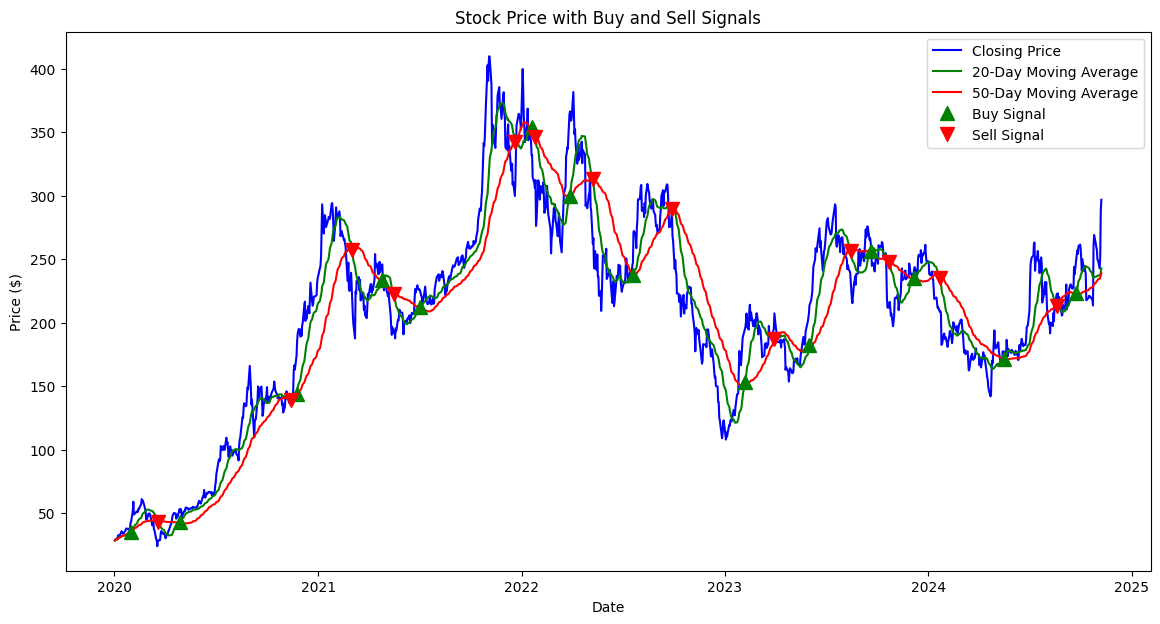

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['SMA'], label=f'{short}-Day Moving Average', color='green')
plt.plot(df['LMA'], label=f'{long}-Day Moving Average', color='red')

# Add buy signals to graph
plt.plot(df[df['Position'] == 1].index, 
         df['SMA'][df['Position'] == 1], 
         '^', markersize=10, color='g', label='Buy Signal')

# Add Sell signals to graph
plt.plot(df[df['Position'] == -1].index, 
         df['SMA'][df['Position'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')

plt.title('Stock Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.show()

## Backtesting

Backtesting evaluates how a trading strategy would have performed in the past by applying it to historical data.

<u><b>Explanation of the code for cumulative returns:</b></u>

<b>1 + df['Strategy_Return']:</b>
- This adds 1 to each element in the Strategy_Return column.
- This is done because we want to calculate the growth factor for each period.
- For instance, if the daily return is 0.02 (2%), adding 1 gives us 1.02, which represents a 2% increase.

<b>cumprod():</b>
- This function calculates the cumulative product of the elements in the resulting series.
It multiplies each element by the cumulative product of all previous elements.
This essentially simulates the compounding effect of returns over time.

<b> -1:</b>
- Finally, subtracting 1 from the cumulative product gives us the overall percentage change in the investment.

In [16]:
# Buy and hold strategy vs. Strategy Return

# Calculate daily returns and cumulative daily returns (buy and hold strategy)
df['Daily_Return'] = df['Close'].pct_change()
df['Cumulative_Daily_Return'] = (1 + df['Daily_Return']).cumprod() - 1

# Calculate strategy returns and cumulative strategy return
df['Strategy_Return'] = df['Daily_Return'] * df['Position'].shift(1)
df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod() - 1

In [17]:
# Display columns
df[['Close', 'Position', 'Daily_Return', 'Strategy_Return', 
            'Cumulative_Daily_Return', 'Cumulative_Strategy_Return']]

Price,Close,Position,Daily_Return,Strategy_Return,Cumulative_Daily_Return,Cumulative_Strategy_Return
Ticker,TSLA,,,,,
Date,,,,,,
2020-01-02 00:00:00+00:00,28.684000,0,NaN,NaN,NaN,NaN
2020-01-03 00:00:00+00:00,29.534000,0,0.029633,0.0,0.029633,0.000000
2020-01-06 00:00:00+00:00,30.102667,0,0.019255,0.0,0.049458,0.000000
2020-01-07 00:00:00+00:00,31.270666,0,0.038801,0.0,0.090178,0.000000
2020-01-08 00:00:00+00:00,32.809334,0,0.049205,0.0,0.143820,0.000000
...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,248.979996,0,-0.003482,-0.0,7.680100,0.639771
2024-11-04 00:00:00+00:00,242.839996,0,-0.024661,-0.0,7.466044,0.639771


### Plotting cumulative daily returns vs. cumulative strategy returns

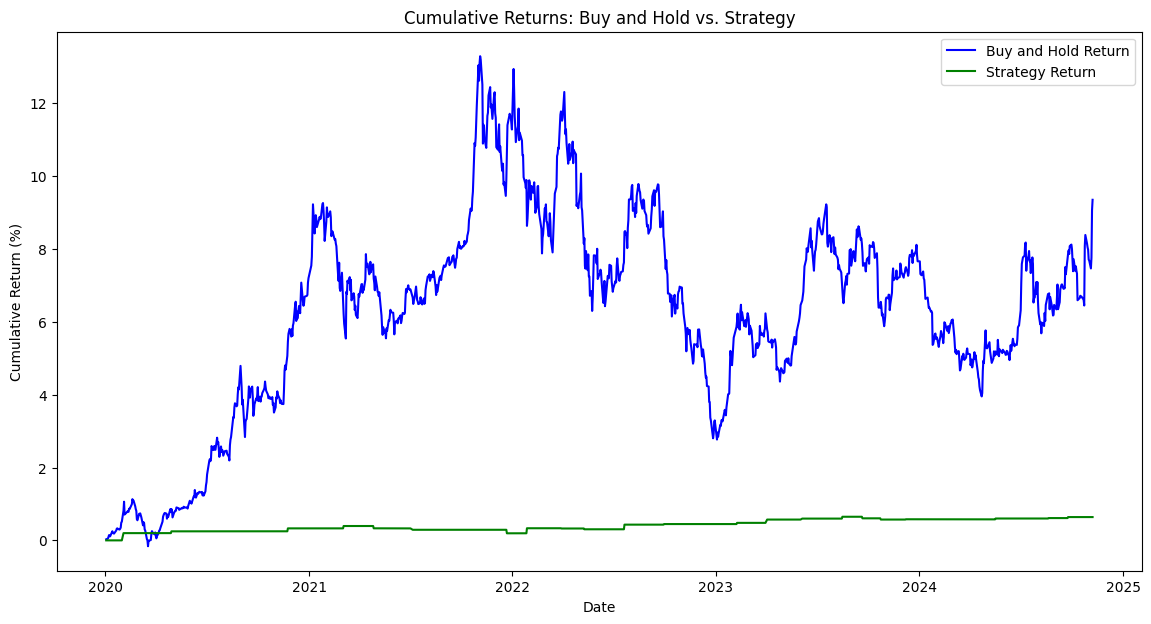

In [18]:
# Plot cumulative returns of the strategy vs. the stock
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative_Daily_Return'], label='Buy and Hold Return', color='blue')
plt.plot(df.index, df['Cumulative_Strategy_Return'], label='Strategy Return', color='green')
plt.title('Cumulative Returns: Buy and Hold vs. Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.show()

### Interpretation of data

Performance Comparison: The Buy and Hold strategy vastly outperforms the moving average strategy in terms of cumulative returns. Despite its volatility, it delivers significant growth over the period.

Risk and Volatility: The moving average strategy may prioritise risk management, resulting in minimal growth but very low volatility. In contrast, Buy and Hold shows high volatility but also much higher potential returns.